In [1]:
import numpy as np
import pandas as pd
import xarray as xr

from datetime import datetime
from metloom.pointdata import SnotelPointData

from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings

def bias(x, y): return np.mean(x - y)

def get_stats(x, y):
    warnings.filterwarnings("ignore", message="An input array is constant")
    if type(x) == xr.DataArray: x = x.values.ravel()
    if type(y) == xr.DataArray: y = y.values.ravel()
    if type(x) == list: x = np.array(x)
    if type(y) == list: y = np.array(y)
    idx = (~np.isnan(x)) & (~np.isnan(y))
    x, y = x[idx], y[idx]
    r, p = pearsonr(x, y)
    b = bias(x, y)
    mae = mean_absolute_error(x, y)
    rmse = mean_squared_error(x, y, squared = False)
    return r, b, mae, rmse

In [3]:
snotel_point = SnotelPointData("312:ID:SNTL", "Banner")
df = snotel_point.get_daily_data(
    datetime(2020, 11, 25), datetime(2021, 3, 15),
    [snotel_point.ALLOWED_VARIABLES.SNOWDEPTH, snotel_point.ALLOWED_VARIABLES.SWE]
)
df =df.droplevel('site')

/tmp/ipykernel_21759/2849123313.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation =0)


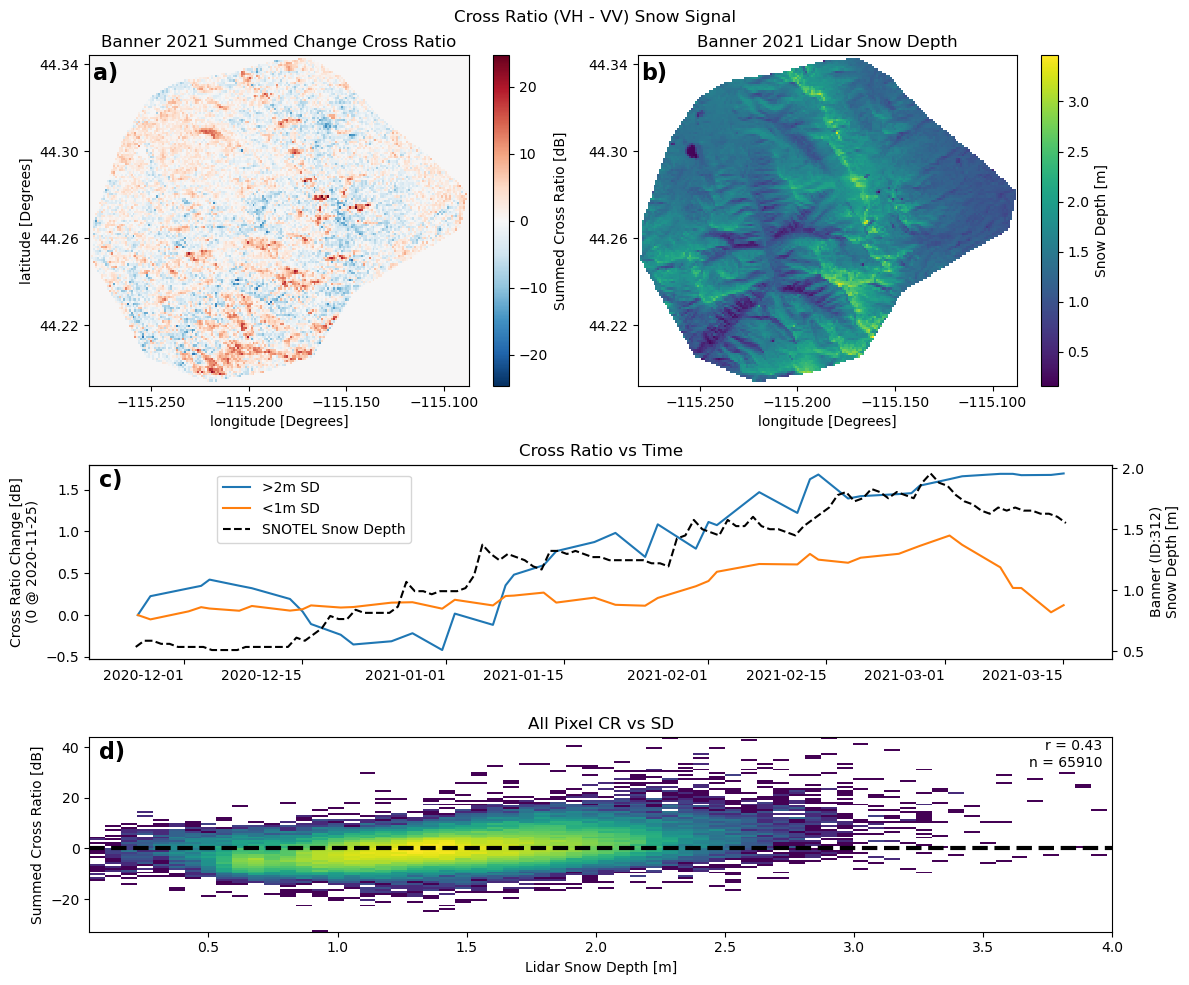

In [17]:
loc_colors = {'Banner_2020-02-18': 'mediumspringgreen', 'Banner_2021-03-15': 'mediumseagreen', 'Cameron_2021-03-19': 'orange', \
    'Dry_Creek_2020-02-19': 'darkorchid', 'Frasier_2020-02-11': 'lightskyblue', 'Frasier_2021-03-19': 'cornflowerblue', \
        'Little_Cottonwood_2021-03-18': 'pink', 'Mores_2020-02-09': 'darkgoldenrod', 'Mores_2021-03-15': 'goldenrod'}


in_dir = Path('~/scratch/spicy/SnowEx-Data/').expanduser().resolve()
dss = {fp.stem: xr.open_dataset(fp) for fp in in_dir.glob('*.nc')}

fig = plt.figure(figsize= (12, 10))
fig.suptitle("Cross Ratio (VH - VV) Snow Signal")

gs1 = GridSpec(7, 2)
ax1 = fig.add_subplot(gs1[:3, :1])
ax2 = fig.add_subplot(gs1[:3, 1:])
ax3 = fig.add_subplot(gs1[3:5, :])
ax4 = fig.add_subplot(gs1[5:, :])
# ax5 = fig.add_subplot(gs1[5:, 1])

# ax5 = fig.add_subplot(gs1[2, 1:])

ds = dss['Banner_2021-03-15']
ds.x.attrs['units'] = 'Degrees'
ds.y.attrs['units'] = 'Degrees'
ds['deltaCR'].where((ds['ims'] == 4) & (~ds['lidar-sd'].isnull())).sum('time').plot(ax = ax1, cbar_kwargs = {'label':'Summed Cross Ratio [dB]'})
ax1.set_xticks(ax1.get_xticks()[2::2], ax1.get_xticklabels()[2::2])
ax1.set_yticks(ax1.get_yticks()[2::2], ax1.get_yticklabels()[2::2])
ds['lidar-sd'].plot(ax = ax2, cbar_kwargs = {'label':'Snow Depth [m]'})
ax2.set_xticks(ax2.get_xticks()[2::2], ax2.get_xticklabels()[2::2])
ax2.set_yticks(ax2.get_yticks()[2::2], ax2.get_yticklabels()[2::2])
ax2.set_ylabel('')


ds['CR'] = ds['s1'].sel(band = 'VH') - ds['s1'].sel(band = 'VV')
ds = ds.sel(time = slice(f'2020-11-15', '2021-03-15'))

hsd = ds['CR'].where(ds['lidar-sd'] > 2).mean(['x', 'y']).rolling(time = 5).mean().dropna('time')
lsd = ds['CR'].where(ds['lidar-sd'] < 1).mean(['x', 'y']).rolling(time = 5).mean().dropna('time')

(hsd - hsd.sel(time = '2020-11-25', method = 'nearest').mean()).plot(ax = ax3, color = 'C0')
(lsd - lsd.sel(time = '2020-11-25', method = 'nearest').mean()).plot(ax = ax3, color = 'C1')

ax3.plot([], [], color = 'C0', label = '>2m SD')
ax3.plot([], [], color = 'C1', label = '<1m SD')
ax3.plot([], [], color = 'black', label = 'SNOTEL Snow Depth', linestyle ='dashed')

ax3_r =ax3.twinx()
sd_m = (df['SNOWDEPTH']*0.0254)
sd_m.plot(ax = ax3_r,color='black', linestyle = 'dashed')
# ax3_r.set_ylim(0.2, 2.1)

xs, ys = [], []
for name, ds in dss.items():
    x = ds['lidar-sd'].data.ravel()
    y = ds['deltaCR'].where((ds['ims'] == 4)).sum(['time']).data.ravel()
    idx = ~np.isnan(x) & ~np.isnan(y) & (y != 0)
    x, y = x[idx], y[idx]
    xs.extend(x)
    ys.extend(y)

r = get_stats(xs, ys)[0]
n = len(xs)
ax4.text(.99, .99, f'r = {r:.2f}\nn = {n}', ha = 'right', va = 'top', transform = ax4.transAxes)
ax4.hist2d(xs, ys, alpha = 1, label = name.split('-')[0], norm = mpl.colors.LogNorm(), bins=100) # , color = loc_colors[name],
ax4.set_xlim(right = 4)
ax4.set_title('All Pixel CR vs SD')
ax4.axhline(0, linestyle ='dashed',color='k', linewidth = 3)

# xs, ys = [], []
# for name, ds in dss.items():
#     x = ds['lidar-sd'].data.ravel()
#     y = ds['deltaCR'].where((ds['ims'] == 4) & (ds['fcf'] < 0.1)).sum(['time']).data.ravel()
#     idx = ~np.isnan(x) & ~np.isnan(y) & (y != 0)
#     x, y = x[idx], y[idx]
#     xs.extend(x)
#     ys.extend(y)

# r = get_stats(xs, ys)[0]
# n = len(xs)
# ax5.text(.99, .99, f'r = {r:.2f}\nn = {n:.1e}', ha = 'right', va = 'top', transform = ax5.transAxes)
# ax5.hist2d(xs, ys, alpha = 1, label = name.split('-')[0], norm = mpl.colors.LogNorm(), bins=50) # , color = loc_colors[name],
# ax5.set_xlim(right = 4)
# ax5.set_title('Treeless Pixels CR vs SD')
# ax4.legend()

for ax, letter in zip([ax1, ax2,ax3, ax4], ['a', 'b','c','d']):
    ax.text(0.01, 0.98,f'{letter})', transform=ax.transAxes, ha = 'left', va = 'top', weight='bold', size = 16)

ax1.set_title('Banner 2021 Summed Change Cross Ratio')
ax2.set_title('Banner 2021 Lidar Snow Depth')

axbox = ax3.get_position()
x_value = 0.0
y_value= 0.2
# fig.legend([line1], ["cos"], loc = (axbox.x0 + x_value, axbox.y0 + y_value))
ax3.legend(loc = (axbox.x0 + x_value, axbox.y0 + y_value))

ax3.set_title('Cross Ratio vs Time')
ax3.set_xlabel('')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation =0)
ax3.set_ylabel('Cross Ratio Change [dB]\n(0 @ 2020-11-25)')
ax3_r.set_ylabel('Banner (ID:312)\nSnow Depth [m]')
ax4.set_xlabel('Lidar Snow Depth [m]')
ax4.set_ylabel('Summed Cross Ratio [dB]')
plt.tight_layout()
plt.savefig('/bsuhome/zacharykeskinen/spicy-analysis/figures/cr/banner2021_cr.png')